In [1]:
import copy

# import cProfile

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as st

import neuro_op as nop

In [2]:
nop.plot_setup()
cmap = "inferno"

In [3]:
# Reference input, to be adapted, just here for reference
input = dict(
    G=nop.build_random_network(N_nodes=100, N_neighbours=5),
    llf_nodes=st.norm,
    params_node=dict(
        loc=0,
        scale=10,
    ),
    sd_llf=1,
    llf_world=st.norm,
    params_world=dict(
        loc=0,
        scale=1,
    ),
    h=1,
    r=1,
    t0=0,
    t_max=100,
    t_sample=1,
    sampling=True,
    init_rngs=False,
    seed=False,
)

In [6]:
# TO THE CLUSTER!

input["t_max"] = 500
nn_arr = np.concatenate((np.arange(0, 10, 2), np.arange(10, 100, 10)))
for nn in nn_arr:
    in_tmp = copy.deepcopy(input)
    in_tmp["G"] = nop.build_random_network(N_nodes=100, N_neighbours=int(nn))
len(nn_arr)

14

In [ ]:
for N_exp in np.arange(
    1,
):
    in_tmp = copy.deepcopy(input)
    N = 10**N_exp
    in_tmp["t_max"] = N
    # Run simulation
    print("t_max = ", t_max)
    t = nop.run_ConjMu(**in_tmp)["t_exec"]
    print("\t =>\t t_exec = ", t)

t_max =  10
	 =>	 t_exec =  0.28002333641052246
t_max =  100
	 =>	 t_exec =  2.209373712539673
t_max =  1000
	 =>	 t_exec =  21.819779634475708
t_max =  10000
	 =>	 t_exec =  236.54178857803345
t_max =  100000


In [33]:
# out1 = nop.run_ConjMu(**nop.input_ref_ConjMu)
out1 = nop.run_ConjMu(**input)

In [34]:
out1["seed"]

150271762191254302694987764278040004794

In [35]:
nop.export_hdf5(out1, "test.h5")
out1 = nop.import_hdf5("test.h5")

## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


#### Data analysis 1

Firstly, extract output values for further analysis:

In [37]:
for i in out1.keys():
    print(i)

world
G
N_events
t_end
t_start
t_exec
seed
nodesConjMu
mu_nodes
sd_nodes
kl_divs



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


(array([ 2.,  3.,  6.,  8., 15., 20.,  4., 17., 10.,  2.,  1.,  6.,  0.,
         0.,  3.,  2.,  0.,  0.,  0.,  1.]),
 array([0.01288419, 0.01381875, 0.0147533 , 0.01568786, 0.01662241,
        0.01755697, 0.01849152, 0.01942608, 0.02036063, 0.02129519,
        0.02222974, 0.0231643 , 0.02409885, 0.02503341, 0.02596796,
        0.02690252, 0.02783707, 0.02877163, 0.02970618, 0.03064074,
        0.03157529]),
 <BarContainer object of 20 artists>)

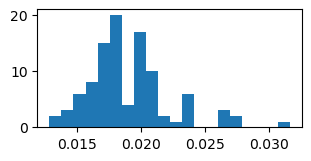

In [38]:
sigmas = []
for i in out1["nodesConjMu"]:
    sigmas += [i.params_node["scale"]]
fig, ax = plt.subplots()
ax.hist(sigmas, bins=20)

[[-1.54332978e+01  6.00000000e+00  1.13166833e-01]
 [-4.02002541e+00 -1.00000000e+00  3.97128345e-01]
 [-5.15531231e+00  6.00000000e+00  4.89660915e-01]
 ...
 [ 1.72902752e+00 -1.00000000e+00  9.99462349e+02]
 [-3.08662746e+00 -1.00000000e+00  9.99689093e+02]
 [-1.21975070e+00  3.50000000e+01  9.99781919e+02]]


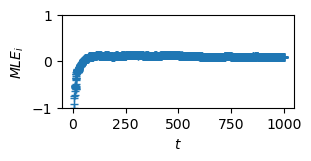

In [39]:
# Implement external sampling routine (or rather test if feasible)
k = 0
nody = out1["nodesConjMu"][k]
# mu_nody = np.array(out1["mu_nodes"])[:, k][1:]
#
fig, ax = plt.subplots()
# ax.plot(
#    np.arange(input["t0"], input["t_max"], input["t_sample"]),
#    mu_nody,
# )

mu, sig = input["params_node"].values()
sd_llf = input["sd_llf"]
x_in = np.array(nody.diary_in)
post_mu = x_in[:, 0]
post_sig = np.zeros_like(post_mu)

i = -1
post_mu[i], post_sig[i] = mu, sig
for i, _ in enumerate(x_in):
    post_mu[i] = (post_sig[i - 1] ** 2 * x_in[i, 0] + sd_llf**2 * post_mu[i - 1]) / (
        post_sig[i - 1] ** 2 + sd_llf**2
    )
    post_sig[i] = (1 / post_sig[i - 1] ** 2 + 1 / sd_llf**2) ** (-0.5)

ax.set_ylim(-1, 1)
ax.plot(x_in[:, 2], post_mu, "+", alpha=1)
ax.set_xlabel("$t$")
ax.set_ylabel("$MLE_i$")

print(nody.diary_in)
# fig.savefig("graphics-output/TMP-mu_N1.png", dpi=1500)

(1001, 100)
1001


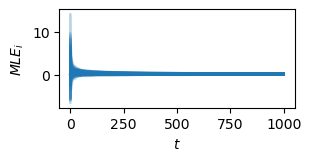

In [40]:
mu_arr = np.array(out1["mu_nodes"])
print(mu_arr.shape)
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
print(len(x))
fig, ax = plt.subplots()
for i, mu in enumerate(mu_arr.T):
    ax.plot(x, mu, alpha=0.3, label=f"$\mu_{i}$", color="tab:blue")
    ax.set_xlabel("$t$")
    ax.set_ylabel("$MLE_i$")
# ax.set_ylim(-100, 100)
# ax.set_yscale("log")
# ax.loglog()
# ax.legend()
# fig.savefig("./graphics-output/TMP-mu_nodes.png", dpi=1500)

#### Data analysis 2

(1, 1000)

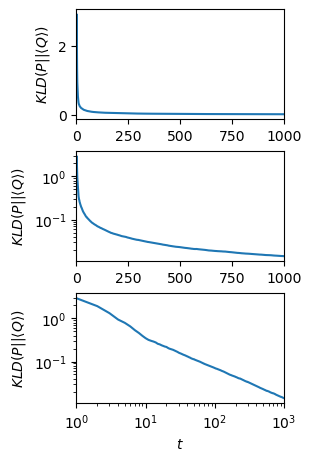

In [41]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
kld = np.array(out1["kl_divs"])
fig, ax = plt.subplots(3, 1, constrained_layout=True, figsize=(3, 4.5))
x = input["t_sample"] * np.arange(0, kld.shape[0])
for i, _ in enumerate(ax):
    ax[i].plot(
        x,  # input["t_sample"] * np.arange(0, kld.shape[0]),
        kld.mean(axis=1),
        label="$KLD_i$",
    )
    ax[i].set_ylabel(r"$KLD(P||\langle Q \rangle )$")
    ax[i].set_xlim(0, x[-1])
ax[2].set_xlabel("$t$")
ax[1].set_yscale("log")
ax[2].loglog()
ax[2].set_xlim(input["t_sample"], input["t_max"])
# fig.savefig("./graphics-output/TMP-KLD.png", dpi=1500)

(1001, 100)


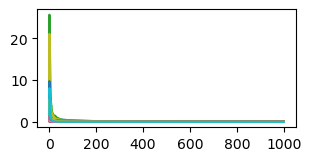

In [42]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
kld = np.array(out1["kl_divs"])
print(kld.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(3, 1.5))
for i, _ in enumerate(kld.T):
    ax.plot(
        input["t_sample"] * np.arange(0, kld.shape[0]),
        kld[:, i],
        label="avg",
    )
# plt.loglog()
# plt.ylim(0, 2)